---

# Setup

##### Set Root Dir as CWD

In [1]:
import os

# Navigate to project root (if not already there)
if os.path.split(os.getcwd())[1] != "cs374-project":
    %cd ../

D:\Documents\A_DIGIPEN\PersonalSVN\Fall22SVN\CS374\Project\cs374-project


##### Imports

In [2]:
import numpy as np
import pandas as pd

import spacy

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Local
from src.preprocesser import ReviewPreprocessor
from src.model import ReviewClassifier

# Load

In [3]:
path = "data/yelp/reviews/"

In [4]:
%%time
# Load dev set (10% of total data) as train
val = pd.read_pickle(path + "val.xz")

CPU times: total: 3.94 s
Wall time: 3.94 s


In [5]:
val

,text,stars
6211529,They are really professional and always sugges...,5
2795691,This is my new favourite sushi restaurant in E...,4
4040968,Fantastic visit here. Hapoy to find it on my a...,5
870450,I have eaten here on a few occasions. There is...,3
5479481,This place is a disgrace. Their customer servi...,1
...,...,...
5103142,I was born and raised in Chicago on thin crust...,5
423717,I love Mee Lu. I will be going back for waxing...,4
4806837,Fun English restaurant/bar in the heart of Phi...,3
6131355,So my wife and I ordered from crave tonight......,3


##### Save Target

In [6]:
# Save reviews stars from 0-4
y_val = tf.convert_to_tensor(val["stars"].values - 1)

# Preprocess

In [7]:
batch_size = 4000
n_processes = 4

maxlen = 200         # Number of words per review to consider
vocab_size = 20_000  # Size of vocabulary

prep_path = f"experiments/preprocessors/final.pickle"

##### Load from raw data

In [8]:
%%time
# Configure preprocessor based on comparison
prep = ReviewPreprocessor.load_from_pickle(prep_path)

# Preprocess text
X_val_norm = prep.normalize(val["text"], batch_size, n_processes)

# Convert to tensor of padded sequences
X_val = prep.to_tensor(X_val_norm)

CPU times: total: 8min 25s
Wall time: 20min 50s


##### View Before and After Preprocessing

In [9]:
print_idx = 8
print(val["text"].iloc[print_idx])
print("\n - - - - \n")
print(X_val_norm[print_idx], len(X_val_norm[print_idx]))
print("\n - - - - \n")
print(X_val[print_idx])

They did a beautiful job remodeling this bar it's absolutely stunning inside and they have a great patio. They just need to work on the customer service and the vibe of the place a little.

 - - - - 

['they', 'did', 'a', 'beautiful', 'job', 'remodeling', 'this', 'bar', 'it', "'", 's', 'absolutely', 'stunning', 'inside', 'and', 'they', 'have', 'a', 'great', 'patio', '.', 'they', 'just', 'need', 'to', 'work', 'on', 'the', 'customer', 'service', 'and', 'the', 'vibe', 'of', 'the', 'place', 'a', 'little', '.'] 39

 - - - - 

tf.Tensor(
[  24  111    6  450  339 6268   26  153   10    9   34  349 3699  319
    3   24   33    6   46  709    1   24   60  242    7  191   29    2
  224   59    3    2  785   11    2   45    6  126    1    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0 

# Model

##### Load Model

In [10]:
# From saved model (doesn't work with attn scores)
#model = keras.models.load_model("experiments/models/final_model")

# From checkpoint
embed_dim = 32  # Attention output size
num_heads = 2   # Number of attention heads
ff_dims = [32]  # Hidden layer sizes in feed forward network inside transformer
reg = 1.0e-2    # L2 Reg based on comparison
dropout = 0.3   # Dropout based on comparison
cp_path = "experiments/model_checkpoints/"
model = ReviewClassifier(maxlen, vocab_size, embed_dim, num_heads, ff_dims, reg, dropout)
model.load_weights(cp_path + f"final.ckpt")

In [11]:
model.predict(X_val[:5])

1/1 [==============================] - 1s 1s/step


array([[1.0663584e-06, 3.5022549e-06, 8.6634001e-04, 8.5881434e-02,
        9.1324764e-01],
       [3.4737499e-05, 1.0860832e-03, 7.6416686e-02, 6.3945198e-01,
        2.8301057e-01],
       [7.6224995e-07, 6.6340817e-06, 2.8881892e-03, 1.9622584e-01,
        8.0087858e-01],
       [4.0096536e-02, 1.9694185e-01, 3.5662508e-01, 3.1959209e-01,
        8.6744413e-02],
       [9.9136001e-01, 8.5916966e-03, 4.8098671e-05, 9.6740777e-08,
        1.2983766e-08]], dtype=float32)

In [12]:
model.summary()

Model: "review_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 t_emb (Embedding)           multiple                  640000    
                                                                 
 p_emb (Embedding)           multiple                  6400      
                                                                 
 attention (MultiHeadAttenti  multiple                 8416      
 on)                                                             
                                                                 
 sequential (Sequential)     (None, 200, 32)           1056      
                                                                 
 layer_normalization (LayerN  multiple                 64        
 ormalization)                                                   
                                                                 
 layer_normalization_1 (Laye  multiple           

# Evaluate

In [13]:
# Get probabilities per class
y_pred = model.predict(X_val)

21845/21845 [==============================] - 30s 1ms/step


In [14]:
# Get star predictions and negative/positive predictions
y_pred_multi = tf.argmax(y_pred, axis=1)

In [15]:
# Calculate continuous star rating based on probabilities
star_reg = tf.reduce_sum(y_pred * np.array([0, 1, 2, 3, 4]), axis=1)
star_reg

<tf.Tensor: shape=(699028,), dtype=float64, numpy=
array([3.91238186, 3.20440443, 3.79807959, ..., 3.11043476, 3.70646865,
       2.18883124])>

In [16]:
y_val

<tf.Tensor: shape=(699028,), dtype=int64, numpy=array([4, 3, 4, ..., 2, 2, 1], dtype=int64)>

In [17]:
tf.reduce_mean(y_val).numpy()

2

In [18]:
# Determine if sentiment is negative or postiive
y_pred_binary = star_reg >= 2

In [19]:
print("multi-class accuracy: " + str((y_pred_multi == y_val).numpy().sum() / len(y_val)))

multi-class accuracy: 0.7017444222549025


In [20]:
print("binary accuracy: " + str((y_pred_binary == (y_val >= 3)).numpy().sum() / len(y_val)))

binary accuracy: 0.9126358314688396


In [21]:
avg_err = tf.reduce_sum(tf.math.abs(y_val - y_pred_multi)) / len(y_val)
avg_err = avg_err.numpy()
print(f"Mean Absolute Error: Average of {avg_err:.4f} stars off")

Mean Absolute Error: Average of 0.3598 stars off


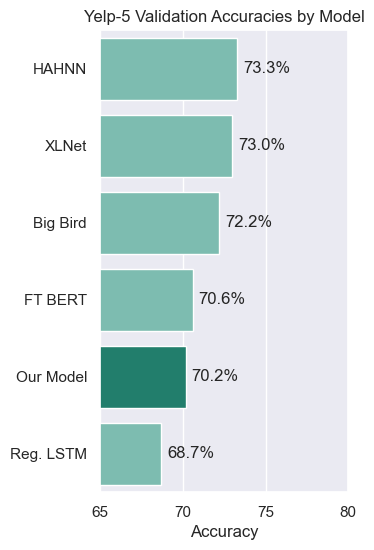

In [22]:
plt.figure(dpi=100, figsize=(3.2, 6))

model_val_names = ["Reg. LSTM", "Our Model", "FT BERT", "Big Bird", "XLNet", "HAHNN"]
model_val_accs = [68.7, 70.2, 70.6, 72.2, 73.0, 73.3]
model_val_names.reverse()
model_val_accs.reverse()

ax = sns.barplot(
    y=model_val_names,
    x=model_val_accs,
    palette=["#73C6B6" if i !=4 else "#138D75" for i in range(6)]
)
plt.xlim(65, 80)
plt.xticks([65, 70, 75, 80])
ax.bar_label(ax.containers[0], fmt="%.1f", padding=4, labels=[str(val) + "%" for val in model_val_accs])

plt.title("Yelp-5 Validation Accuracies by Model")
plt.xlabel("Accuracy")

plt.show()

##### Visualize Attention

In [23]:
# Get attention scores
_, attns = model(X_val[:100], return_att=True)

# Get attention for each sample
attns = tf.reduce_mean(attns, axis=2)[:, 0, :]
attns

<tf.Tensor: shape=(100, 200), dtype=float32, numpy=
array([[6.4615138e-02, 1.4064997e-01, 1.9586211e-01, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.5692554e-04, 1.1812446e-02, 9.8764477e-03, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [2.6472425e-01, 1.6547798e-01, 5.0601619e-03, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [8.6857425e-04, 2.7973267e-01, 3.8277071e-02, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [4.5533672e-02, 1.1269929e-01, 1.1367991e-01, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [5.0139528e-02, 6.8314822e-04, 3.9479566e-01, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)>

In [24]:
attns[0][:34]

<tf.Tensor: shape=(34,), dtype=float32, numpy=
array([0.06461514, 0.14064997, 0.19586211, 0.25356346, 0.00168195,
       0.00205253, 0.04743958, 0.01235273, 0.11597173, 0.00608554,
       0.03024661, 0.06855658, 0.00159435, 0.05932764, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ], dtype=float32)>

<Original Text>
They did a beautiful job remodeling this bar it's absolutely stunning inside and they have a great patio. They just need to work on the customer service and the vibe of the place a little.

<Preprocessed>
['they', 'did', 'a', 'beautiful', 'job', 'remodeling', 'this', 'bar', 'it', "'", 's', 'absolutely', 'stunning', 'inside', 'and', 'they', 'have', 'a', 'great', 'patio', 'they', 'just', 'need', 'to', 'work', 'on', 'the', 'customer', 'service', 'and', 'the', 'vibe', 'of', 'the', 'place', 'a', 'little']


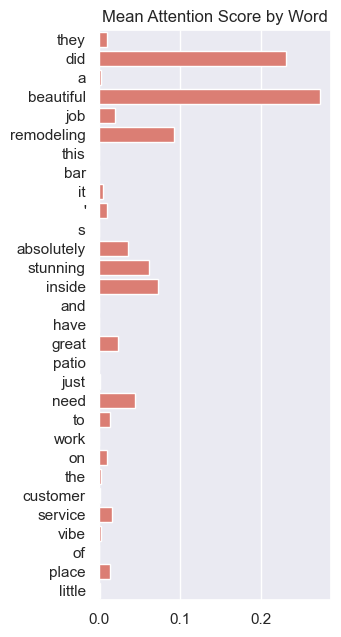

In [25]:
sample_idx = 8

# Get word sequences without oov words
in_seq = X_val_norm[sample_idx][:maxlen]
in_seq = [tok for tok in prep.tokenizer.sequences_to_texts(prep.tokenizer.texts_to_sequences(in_seq)) if tok]
seq_len = len(in_seq)

# Get attention values
attn_vals = attns[sample_idx][:seq_len].numpy()

print("<Original Text>")
print(val["text"].iloc[sample_idx])

print("\n<Preprocessed>")
print(in_seq)

plt.figure(figsize=(3, 0.2 * seq_len), dpi=100)
sns.barplot(y=in_seq, x=attn_vals, ci=None, color="#EC7063")

plt.title("Mean Attention Score by Word")

#plt.gca().set_yticklabels(in_seq)

plt.show()

# Binary Classification Scores

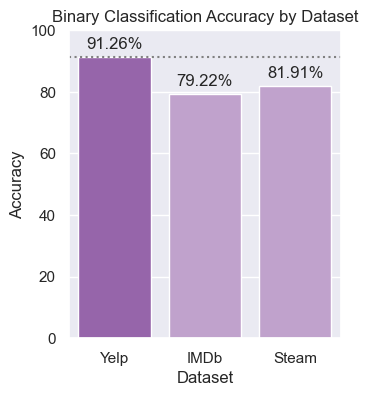

In [135]:
plt.figure(figsize=(3.5, 4.0), dpi=100)

dataset_names = ["Yelp", "IMDb", "Steam"]
bin_class_scores = [91.26, 79.22, 81.91]

ax = sns.barplot(
    x=dataset_names,
    y=bin_class_scores,
    palette=["#9B59B6" if i ==0 else "#C39BD3" for i in range(6)]
)
plt.axhline(bin_class_scores[0], color="grey", linestyle=":")
plt.ylim(0, 100)
ax.bar_label(ax.containers[0], fmt="%.2f", padding=4, labels=[str(val) + "%" for val in bin_class_scores])

plt.title("Binary Classification Accuracy by Dataset")
plt.ylabel("Accuracy")
plt.xlabel("Dataset")

plt.show()